In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tests.leandro.hierarchical_clustering import *
from tests.leandro.hierarchical_clustering_analysis import *
from tests.leandro.tools import get_real_data, get_one_worm_data
import itertools

In [3]:
# Real data
dataset = get_real_data("/home/lrvnc/Projects/worm-graph/conf/dataset.yaml")


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50



In [7]:
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset, wormid="worm9")

Worm ID: worm9


# Clustering the data
---

To initiate a hierarchical cluster analysis, we can invoke the function `hierarchical_clustering_analysis`, providing the dataset specific to one worm and specifying the desired number of clusters as parameters.

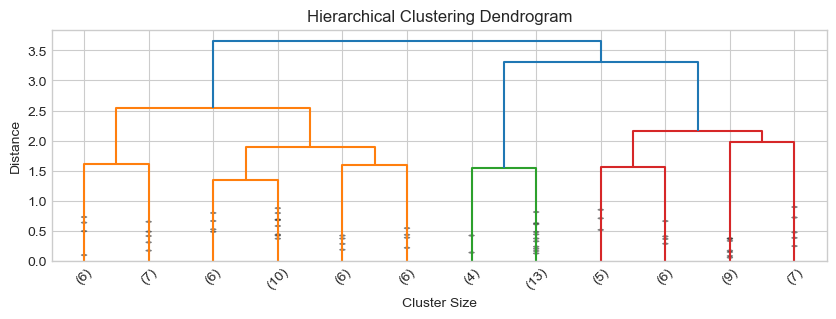

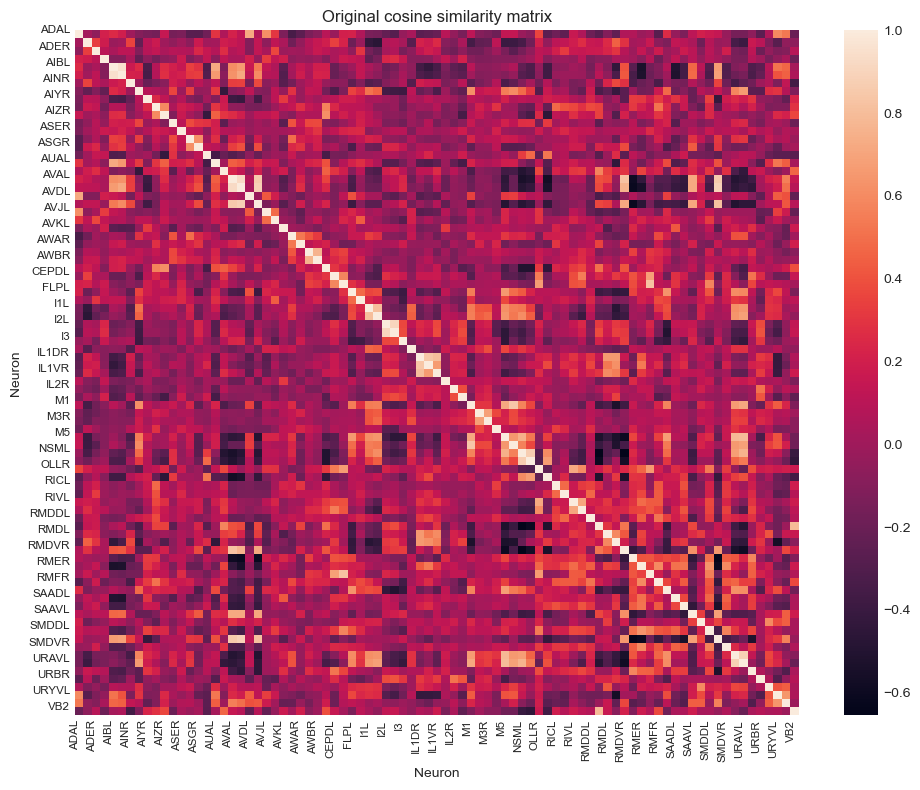

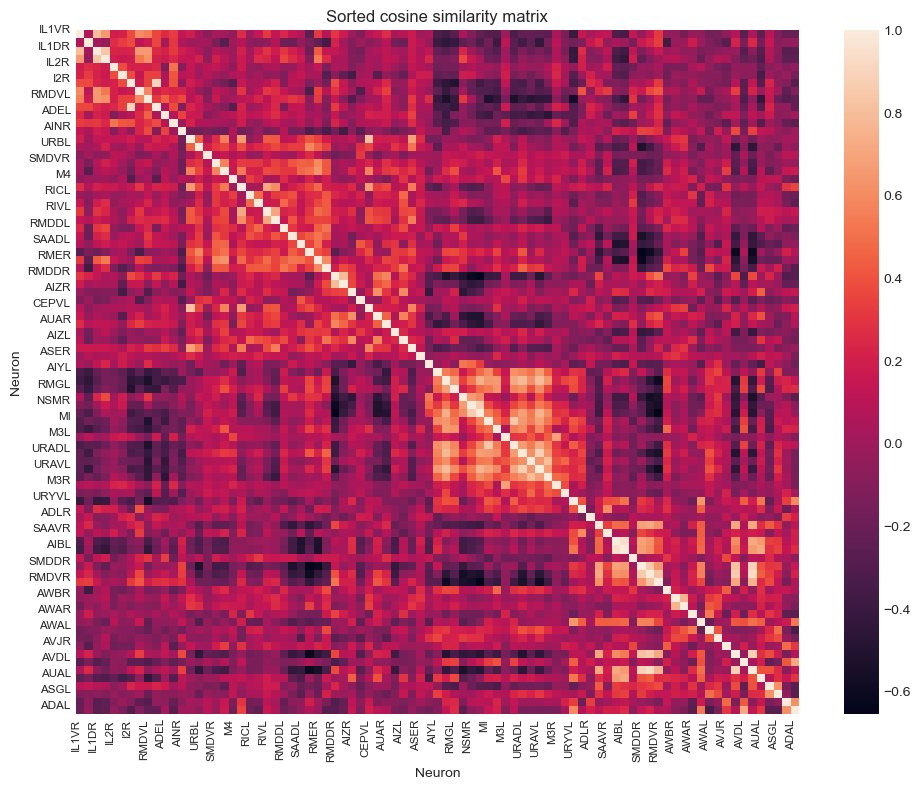

Silhouette average: 0.2796


In [8]:
clusters, silhouette_avg = hierarchical_clustering_algorithm(
    oneWorm, criterion_value=4, show_plots=True, distance="cosine"
)
print("Silhouette average:", silhouette_avg.round(4))

The function returns a single dataframe containing the neuron name as index, their computed cluster labels and the corresponding classification that can be found in the literature. It also returns the Silhouette average $\in [-1, 1]$, a metric that quantify the quality of the clustering.

> *S* stands for *Sensory*, *M* for *Motor*, *I* for *Interneuron* and *P* for *Polymodal*

In [8]:
clusters.head()

,Computed Cluster,Reference
Neuron,,
IL1VR,1,SMI
I3,1,SI
IL1DR,1,SMI
IL1R,1,SMI
IL2R,1,S


The computed clusters can vary based on the chosen criterion, metric, and method. Here are the options available for exploration:

* Method:
    - 'single': Uses the minimum distance between observations in different clusters.
    - 'complete': Uses the maximum distance between observations in different clusters.
    - 'average': Uses the average distance between observations in different clusters.
    - 'weighted': Uses the weighted distance between observations in different clusters.
    - 'centroid': Uses the distance between centroids of clusters.
    - 'median': Uses the distance between medians of clusters.
    - 'ward': Minimizes the variance when merging clusters. ([More details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html))

* Metric:
    - Various distance metrics can be used to compute the pairwise distances between observations. Some common options include Euclidean distance, Manhattan distance, and correlation distance. The complete list of possibilities can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist).

* Criterion:
    - 'inconsistent': Provides statistics on the inconsistency of clusters.
    - 'distance': Forms flat clusters based on a specified distance threshold.
    - 'maxclust': Forms flat clusters by specifying the desired number of clusters.
    - 'monocrit': Forms flat clusters based on a specific monocriterion.
    - 'maxclust_monocrit': Forms flat clusters based on a monocriterion with a specified number of clusters. ([More details](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster))

# Analysis tools
---

To begin the analysis, let's examine the distribution of neurons according to the literature. Since different neural datasets may have different neuron subsamples, we can group the neurons in three different ways:

> 1. Using the classification from the literature directly: Neurons are classified into the following categories: Sensory (S), Motor (M), Interneuron (I), Sensory-Interneuron (SI), Motor-Interneuron (MI), Sensory-Motor (SM), Sensory-Motor-Interneuron (SMI), and Unknown neurons (U).
>
> 2. Grouping the neurons into four classes: Neurons are grouped into the following categories: Sensory (S), Motor (M), Interneuron (I), and Polymodal (P).
>
> 3. Grouping the neurons into three classes: Neurons are grouped into the following categories: Sensory (S), Motor (M), and Interneuron (I).

For the third grouping method, we assume that during the period when the neural data was collected, polymodal neurons had a single function. We randomly assign the function of polymodal neurons to one of the three classes (S, M, or I), with equal probability for each class.

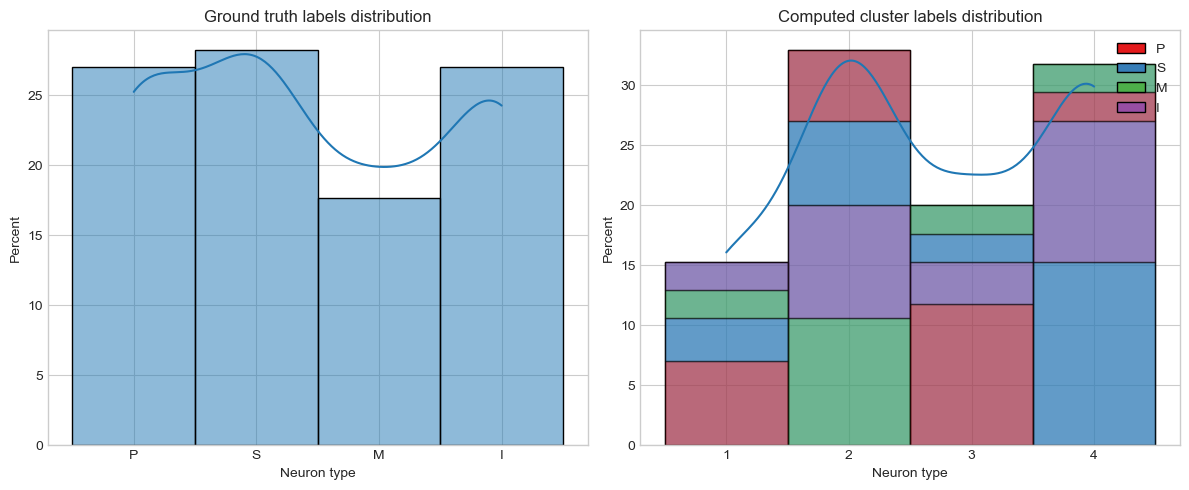

In [9]:
group_by = "four"

# We start creating the reference dictionary
ref_dict = load_reference(
    group_by=group_by
)  # None for eight groups, 'three' for three groups, 'four' for four groups

# stat = 'percent', 'count', 'proportion', 'density'
# group_by =  None, 'three', 'four'
grouped_clusters = neuron_distribution(
    clusters,
    ref_dict,
    stat="percent",
    group_by=group_by,
    show_plots=True,
    plot_type="both",
)

Continuing the analysis, we can count the occurrences of each neuron type inside each computed cluster to gain insights into their respective roles. You have the option to choose whether to view the results as percentages or absolute counts.

In [10]:
# percentage = True (%) or False (count)
# dimension = 'reference' or 'computed-cluster'
count_df = count_inside_clusters(
    grouped_clusters, percentage=True, dimension="computed-cluster"
)
count_df

Reference,I,M,P,S,total
Computed Cluster,,,,,
1,15.38,15.38,46.15,23.08,100.0
2,28.57,32.14,17.86,21.43,100.0
3,17.65,11.76,58.82,11.76,100.0
4,37.04,7.41,7.41,48.15,100.0
total,27.06,17.65,27.06,28.24,100.0


To further assist in analyzing the computed clusters, you can utilize the suggestion function, which provides recommendations regarding the role of a given cluster. The function offers two suggestions:

> 1. The first suggestion highlights the neuron type with the highest proportion within a particular cluster. This suggestion helps identify the predominant neuron type  within the cluster, offering insights into its potential role.
> 
> 2. The second suggestion identifies the cluster that exhibits the highest proportion for a specific neuron type, in a given dataset. This suggestion allows you to identify clusters that are particularly enriched in a particular neuron type, providing further clues about its potential function.

In [11]:
suggestion = suggest_classification(grouped_clusters)
print(
    "mapping: {}, unique values: {}".format(
        suggestion["hip1"], np.unique([c for c in suggestion["hip1"].values()])
    )
)

mapping: {1: 'P', 2: 'M', 3: 'P', 4: 'S'}, unique values: ['M' 'P' 'S']


# Investigating best clustering parameters
---

In this investigation, our objective is to determine the optimal choice of *metric* and *method* for the clustering analysis. To accomplish this, we will perform the following steps:

1. For each combination of *method* and *metric*, we will cluster all the worms in the dataset.

2. We will calculate the silhouette score for each individual worm, which measures the quality of the clustering results. 

3. To obtain an overall measure, we will compute the average of the silhouette scores across all worms for each *(method, metric)* pair.

4. The resulting average silhouette scores will serve as an indicator of the effectiveness of each clustering approach.

By comparing the average silhouette scores across different *(method, metric)* pairs, we can determine which combination yields the most optimal clustering results for our dataset. This analysis will enable us to identify the best combination of *method* and *metric* that maximizes the quality and accuracy of the clustering analysis.

In [10]:
methods = ["single", "complete", "average", "weighted"]
metrics = [
    "euclidean",
    "minkowski",
    "cityblock",
    "seuclidean",
    "sqeuclidean",
    "cosine",
    "correlation",
    "hamming",
    "jaccard",
    "jensenshannon",
    "chebyshev",
    "canberra",
    "braycurtis",
    "mahalanobis",
    "yule",
    "matching",
    "dice",
    "kulczynski1",
    "rogerstanimoto",
    "russellrao",
    "sokalmichener",
    "sokalsneath",
    "kulczynski1",
]

possible_clustering_parameters = list(itertools.product(methods, metrics))
possible_clustering_parameters.append(("ward", None))
# possible_clustering_parameters.append(('median', None))

num_computed_clusters = 4

group_by = "four"

if group_by == "four":
    groups = 4
elif group_by == "three":
    groups = 3
else:
    groups = 7

stat = "percent"

distance_metric = "correlation"

In [11]:
silhouettes = []

for method, metric in possible_clustering_parameters:
    worm_silhouettes = []

    for i, wormID in enumerate(dataset.keys()):
        clusters, silhouette_avg = hierarchical_clustering_algorithm(
            dataset[wormID],
            distance=distance_metric,
            method=method,
            metric=metric,
            show_plots=False,
            criterion="maxclust",
            criterion_value=num_computed_clusters,
        )

        worm_silhouettes.append(silhouette_avg)

    # print(f"Method: {method}, Metric: {metric}, Silhouette: {np.mean(worm_silhouettes).round(4)}, Cluster labels: {clusters['Computed Cluster'].unique()}")

    silhouettes.append(np.mean(worm_silhouettes))

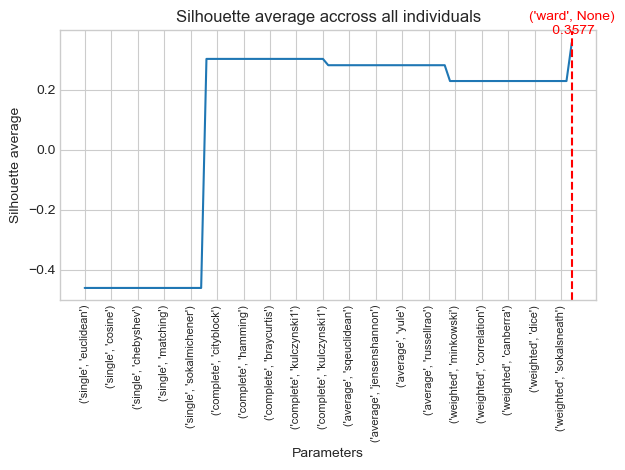

In [12]:
plt.plot(silhouettes)
plt.title("Silhouette average accross all individuals")
plt.xlabel("Parameters")
plt.ylabel("Silhouette average")
plt.xticks(
    range(len(possible_clustering_parameters)),
    possible_clustering_parameters,
    rotation=90,
)
# reduce the number of ticks
plt.locator_params(axis="x", nbins=20)
# reduce xticks font size
plt.xticks(fontsize=8)
# show the best option (max value)
plt.axvline(np.argmax(silhouettes), color="red", linestyle="--")
# write the best option
plt.text(
    np.argmax(silhouettes) - 8,
    np.max(silhouettes) + 0.03,
    f"{possible_clustering_parameters[np.argmax(silhouettes)]}\n      {np.max(silhouettes).round(4)}",
    color="red",
)
# write value of the best option
plt.tight_layout()
plt.show()

After testing all possible combinations, we have determined that the ward method exhibits the best silhouette performance. Interestingly, it appears that the choice of distance metric does not significantly influence the average quality of the clusters. This observation is reflected in plateaus in the graph, indicating that the clustering separation method plays a more influential role in determining the clustering performance.

# Accuracy
---

In [13]:
(
    all_worm_clusters,
    ref_dict,
    count_inside_clusters_array,
    silhouettes,
) = hc_analyse_dataset(
    dataset,
    apply_suggestion=True,
    hip="hip1",
    group_by="four",
    method="ward",
    metric=None,
)

# Average accuracy across all individuals
print(
    f"Average acc across individuals: {np.mean(all_worm_clusters.loc['accuracy']).round(4)}"
)
# Averace accuracy for each neuron
print(f"Average acc for each neuron: {np.mean(all_worm_clusters['accuracy']).round(4)}")

delete_ref_column(all_worm_clusters)

Number of worms: 50
Suggestion applied: hip1.
Average acc across individuals: 0.407
Average acc for each neuron: 0.4518


,worm0,worm1,worm2,worm3,worm4,worm5,worm6,worm7,worm8,worm9,...,worm41,worm42,worm43,worm44,worm45,worm46,worm47,worm48,worm49,accuracy
Neuron,,,,,,,,,,,,,,,,,,,,,
ADAL,I,S,I,S,NaN,NaN,I,I,NaN,S,...,I,I,S,NaN,S,NaN,I,I,S,0.621622
AVJR,I,P,I,I,S,P,NaN,S,I,S,...,I,I,I,I,P,I,M,NaN,I,0.538462
AVKL,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,M,...,NaN,I,NaN,NaN,NaN,NaN,I,NaN,S,0.692308
AVL,I,NaN,NaN,S,I,I,NaN,NaN,NaN,NaN,...,NaN,NaN,S,NaN,NaN,P,NaN,I,I,0.241379
AWBL,I,S,I,P,P,P,P,S,I,S,...,NaN,S,P,NaN,S,NaN,P,NaN,S,0.340909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RIBR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,P,NaN,NaN,NaN,NaN,I,0.571429
RMGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,I,NaN,I,NaN,NaN,NaN,0.750000
AVBR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,P,NaN,P,NaN,NaN,NaN,0.600000


# Silhouette Average
---

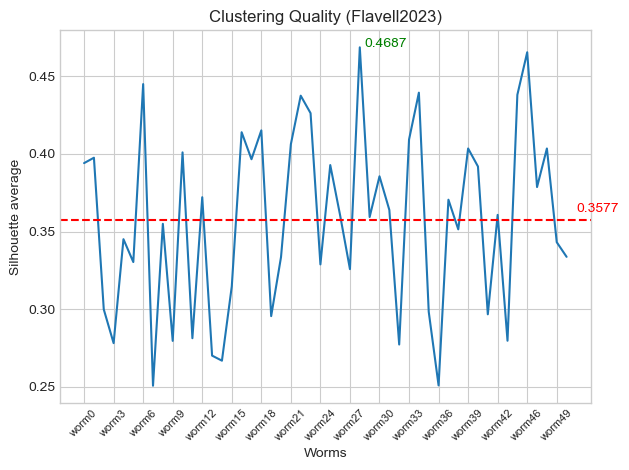

In [14]:
# Plot silhouette average
plt.plot(silhouettes)
plt.title("Clustering Quality (Flavell2023)")
plt.xlabel("Worms")
plt.ylabel("Silhouette average")
plt.xticks(range(len(silhouettes)), dataset.keys(), rotation=45)
# reduce the number of ticks
plt.locator_params(axis="x", nbins=20)
# reduce xticks font size
plt.xticks(fontsize=8)

# write the value of the best option
plt.text(
    np.argmax(silhouettes) + 0.5,
    np.max(silhouettes),
    f"{np.max(silhouettes).round(4)}",
    color="green",
)

# draw horizontal line with the average and write it
plt.axhline(np.mean(silhouettes), color="red", linestyle="--")
plt.text(
    len(silhouettes),
    np.mean(silhouettes) + 0.005,
    f"{np.mean(silhouettes).round(4)}",
    color="red",
)

plt.tight_layout()
plt.show()

# Neurons of different clusters are connected?
---

In [30]:
import torch
import os
from utils import ROOT_DIR
from torch_geometric.data import Data

# load the connectome data
graph_tensors = torch.load(
    os.path.join(ROOT_DIR, "data", "processed", "connectome", "graph_tensors.pt")
)

# make the graph
graph = Data(**graph_tensors)

print("Graph attributes: {}".format(graph.keys))
print(
    "Num. nodes: {}, Num. edges: {}, Num. node features: {}".format(
        graph.num_nodes, graph.num_edges, graph.num_node_features
    )
)

Graph attributes: ['num_classes', 'y', 'node_type', 'idx_to_neuron', 'x', 'edge_index', 'edge_attr', 'pos', 'n_id']
Num. nodes: 302, Num. edges: 4396, Num. node features: 1024


In [34]:
def get_connected_neurons(graph, neuron_name, index=False):
    neuron_to_idx = {u: v for (v, u) in graph.idx_to_neuron.items()}
    idx_to_neuron = {v: u for (v, u) in graph.idx_to_neuron.items()}

    # Get the edge indices corresponding to the given node
    node_index = neuron_to_idx[neuron_name]
    connected_edge_indices = (graph.edge_index[0] == node_index).nonzero()

    # Get the connected nodes by extracting the second row of the connected_edge_indices
    connected_nodes = graph.edge_index[1, connected_edge_indices].flatten()

    if index == True:
        return connected_nodes.detach().numpy()
    else:
        return np.array(
            [idx_to_neuron[idx] for idx in connected_nodes.detach().numpy()]
        )


def is_connected(graph, neuron1, neuron2):
    connected_neurons = get_connected_neurons(graph, neuron1)

    if neuron2 in connected_neurons:
        return True
    else:
        return False

In [17]:
(
    all_worm_clusters,
    ref_dict,
    count_inside_clusters_array,
    silhouettes,
) = hc_analyse_dataset(
    dataset,
    apply_suggestion=False,
    hip="hip1",
    group_by="four",
    method="ward",
    metric=None,
)
all_worm_clusters.head()

Number of worms: 50
No suggestion applied, ignoring hip parameter.


,worm0,worm1,worm2,worm3,worm4,worm5,worm6,worm7,worm8,worm9,...,worm41,worm42,worm43,worm44,worm45,worm46,worm47,worm48,worm49,Reference
Neuron,,,,,,,,,,,,,,,,,,,,,
ADAL,1.0,2.0,3.0,3.0,NaN,NaN,1.0,3.0,NaN,4.0,...,4.0,4.0,2.0,NaN,1.0,NaN,1.0,1.0,4.0,I
AVJR,1.0,1.0,3.0,2.0,4.0,4.0,NaN,2.0,1.0,4.0,...,4.0,4.0,4.0,2.0,2.0,2.0,3.0,NaN,1.0,I
AVKL,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,4.0,I
AVL,1.0,NaN,NaN,3.0,1.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,3.0,NaN,2.0,3.0,P
AWBL,1.0,2.0,4.0,4.0,3.0,4.0,2.0,4.0,3.0,4.0,...,NaN,3.0,1.0,NaN,1.0,NaN,4.0,NaN,4.0,S


In [32]:
oneWorm_cluster = all_worm_clusters[["worm9", "Reference"]].dropna()
oneWorm_cluster.head()

,worm9,Reference
Neuron,,
ADAL,4.0,I
AVJR,4.0,I
AVKL,2.0,I
AWBL,4.0,S
AWBR,4.0,S


In [50]:
for n in oneWorm_cluster.loc[oneWorm_cluster["worm9"] == 1].index:
    print(n, is_connected(graph, n, "URBR"))

RMDL False
I3 False
I2L False
I2R False
IL2R True
IL2VR False
IL1R False
ADEL False
URBR False
IL1VR False
IL1DR False
RMDVL False
AINR False


# Do we have a group of neurons that are always clustered together?
---

In [17]:
(
    all_worm_clusters,
    ref_dict,
    count_inside_clusters_array,
    silhouettes,
) = hc_analyse_dataset(dataset, apply_suggestion=False, group_by="four")
all_worm_clusters = delete_ref_column(all_worm_clusters)
all_worm_clusters.dropna()

Number of worms: 50
No suggestion applied, ignoring hip parameter.


,worm0,worm1,worm2,worm3,worm4,worm5,worm6,worm7,worm8,worm9,...,worm40,worm41,worm42,worm43,worm44,worm45,worm46,worm47,worm48,worm49
Neuron,,,,,,,,,,,,,,,,,,,,,
M3L,2.0,2.0,2.0,4.0,2.0,4.0,4.0,1.0,2.0,3.0,...,3.0,3.0,2.0,3.0,2.0,4.0,2.0,4.0,4.0,4.0


Among all the labeled neurons in the dataset, there is only one neuron that had its activity registered for all animals! But how about counting the number of times that two diferent neurons were clustered together?

Number of neuron groups: 20


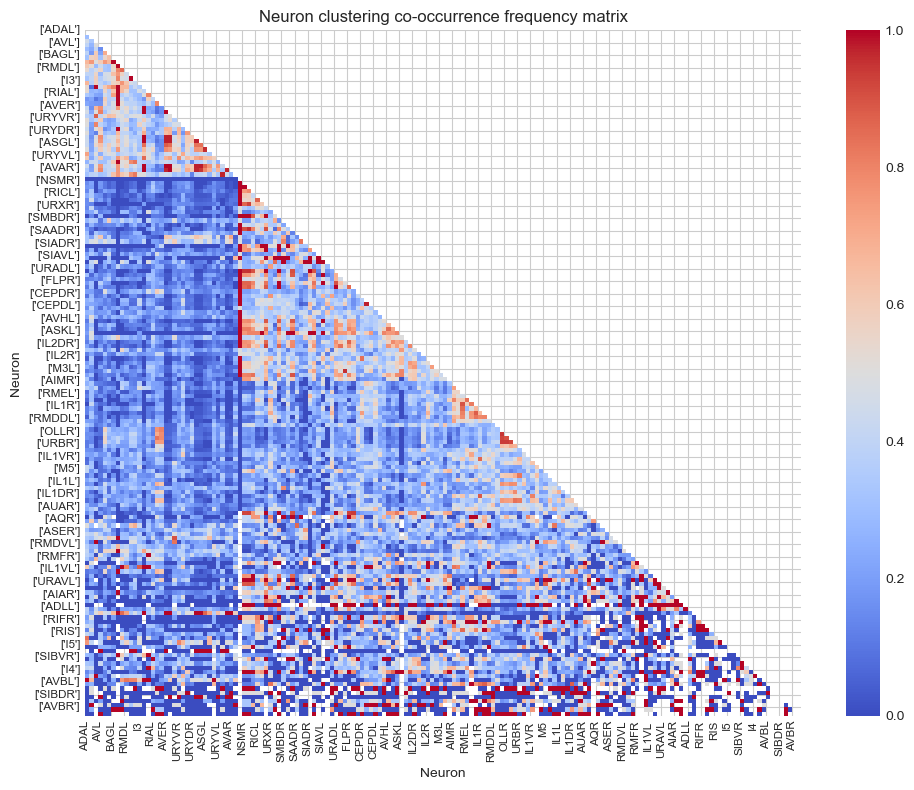

In [18]:
new_groups_temp = group_frequency(
    all_worm_clusters, neuron_groups=None, ocurr_threshold=10
)

This function allows us to identify groups of neurons that were simultaneously recorded more than a specified threshold (occur_threshold) number of times and were consistently clustered together by our hierarchical clustering algorithm across all runs.

In [19]:
occur_threshold = 10
group_sizes = []

new_groups_temp = group_frequency(
    all_worm_clusters,
    neuron_groups=None,
    ocurr_threshold=occur_threshold,
    show_plot=False,
    verbose=False,
)

while len(new_groups_temp) > 4:
    print("{} groups of size {}".format(len(new_groups_temp), len(new_groups_temp[0])))
    new_group = new_groups_temp
    group_sizes.append(len(new_groups_temp))
    new_groups_temp = group_frequency(
        all_worm_clusters,
        neuron_groups=new_groups_temp,
        ocurr_threshold=occur_threshold,
        show_plot=False,
        verbose=False,
    )

20 groups of size 2
23 groups of size 3
17 groups of size 4
5 groups of size 5


In [20]:
_ = count_clustered_times(all_worm_clusters, new_group[2], verbose=True)

The neurons '['AIBL', 'AIBR', 'AVAL', 'AVER', 'RIMR']' were clustered together 11 times (out of 11).


In [21]:
for ng in new_group:
    print(ng)

['AIBL', 'AIBR', 'AVAL', 'AVEL', 'RIML']
['AIBL', 'AIBR', 'AVAL', 'AVER', 'RIML']
['AIBL', 'AIBR', 'AVAL', 'AVER', 'RIMR']
['AIBL', 'AIBR', 'AVEL', 'AVER', 'RIML']
['I1L', 'I1R', 'NSML', 'NSMR', 'URADL']


# Boxplot
---

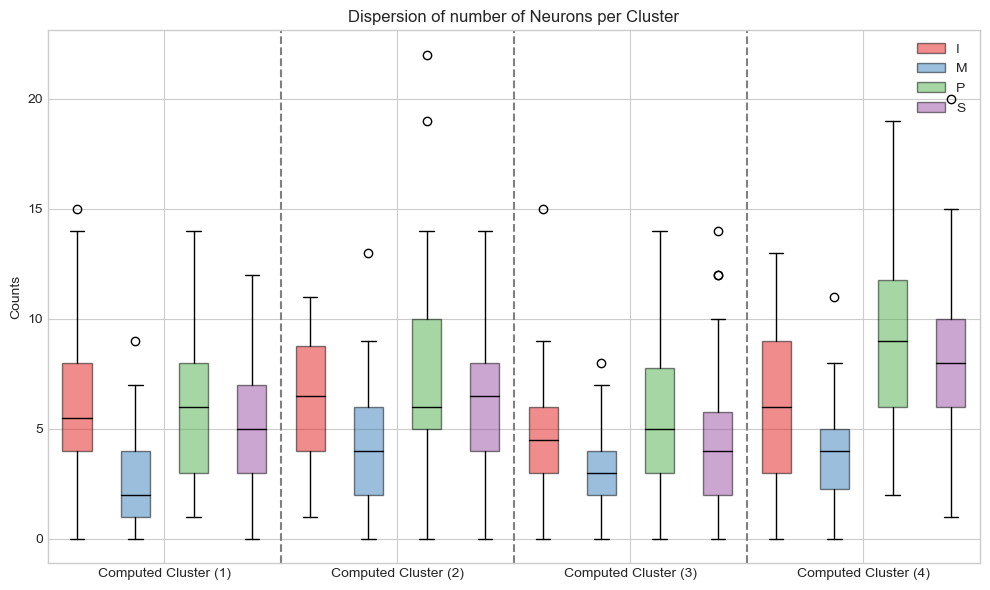

In [22]:
count_boxplot(count_inside_clusters_array)

# PCA
---

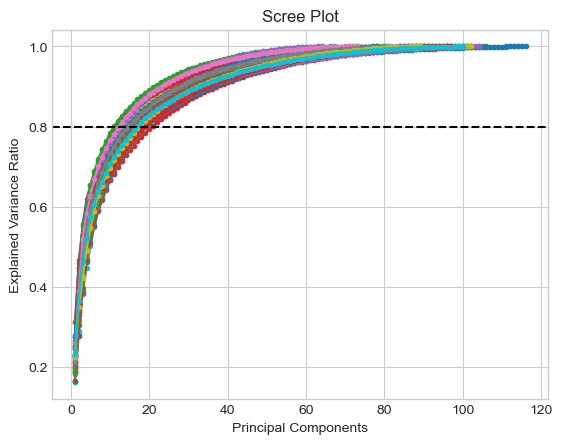

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for wormid, data in dataset.items():
    time_series_matrix = data["smooth_calcium_data"]  # (time, all neurons)
    time_series_matrix = (
        time_series_matrix[:, data["named_neurons_mask"]].detach().numpy()
    )  # (time, named and acive neurons)

    # Apply PCA
    pca = PCA()
    pca.fit(time_series_matrix)

    # Calculate explained variance and cumulative explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Create scree plot
    plt.plot(
        np.arange(1, len(explained_variance) + 1),
        cumulative_explained_variance,
        marker=".",
    )

plt.axhline(y=0.8, color="black", linestyle="--")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()